 "data.csv"中存有幅值220V，频率50Hz，初相位为0，采样频率10kHz，时间长度为1s的电压数据。已知电压中存在幅值、相位各不相同的谐波(谐波幅值低于基波1%可忽略不计)，尝试：
 (1) 将给定数据降采样至1kHz；
 (2) 对降采样后的数据进行FFT分析，确定存在何种频率的谐波，及其幅值、相位，如果可能的话给出电压原始信号的数值表达式(选做)；
 (3) 滤除谐波，并将滤波后的信号还原，分别与目标信号(y=220*sin(2*pi*50*x))与原始信号比较。

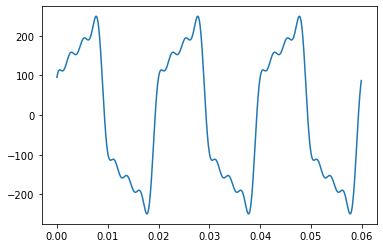

In [1]:
# 取出数据
import pandas as pd  # 用来读取csv中数据
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft
import math

data = pd.read_csv('data.csv').values  # 读取数据并将数据结构变成ndarray以便numpy处理
x = data[:, 0]  # 取出时间
y = data[:, 1]  # 取出电压
plt.plot(x[:600], y[:600])

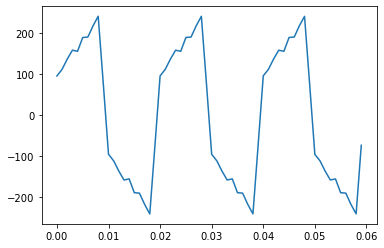

In [2]:
# 降采样
x = x[::10]
y = y[::10]

plt.plot(x[:60], y[:60])

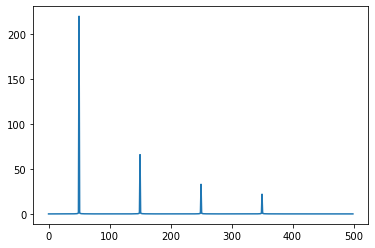

In [3]:
# FFT
fft_y = fft(y)
N = len(x)
fs = 1000
amplitude = 220
f = np.linspace(0, N-1, N) / N * fs
normed_abs_y = np.abs(fft_y) / (N / 2)

half_f = f[:int(N/2)]
half_normed_abs_y = normed_abs_y[:int(N/2)]

plt.plot(half_f, half_normed_abs_y)

In [4]:
# 利用谐波幅值低于基波1%忽略不计来筛选谐波
harmonic_f = list()  # 用以存储谐波(与基波)频率
harmonic_a = list()  # 用以存储谐波(与基波)幅值
idx = list()  # 用以存储谐波(与基波)在ndarray中的索引
for i in range(len(half_f)):
    if half_normed_abs_y[i] > 0.01 * amplitude:
        print("Frequency: {}; Amplitude: {}".format(
            half_f[i], half_normed_abs_y[i]))
        harmonic_f.append(half_f[i])
        harmonic_a.append(half_normed_abs_y[i])
        idx.append(i)
print(idx)


Frequency: 50.0; Amplitude: 219.98315362209286
Frequency: 150.0; Amplitude: 65.96614913555831
Frequency: 250.0; Amplitude: 32.95860864715462
Frequency: 350.0; Amplitude: 21.94891221500777
[50, 150, 250, 350]


In [5]:
# 计算相位(选做)与表达式
# 将上述存储的谐波频率(idx[1:])对应的相位与基波频率(idx[0])对应的相位做差并存储即可
# 已求得幅值与相位差，故可以求出原始信号的表达式
harmonic_p = list()
for j in idx[1:]:
    print("Phase of frequency of {} Hz is: {}".format(
        half_f[j], np.angle(fft_y[j]) - np.angle(fft_y[idx[0]])))
    harmonic_p.append(np.angle(fft_y[j]) - np.angle(fft_y[idx[0]]))

Phase of frequency of 150.0 Hz is: 0.8170501624603445
Phase of frequency of 250.0 Hz is: 1.634236985375895
Phase of frequency of 350.0 Hz is: 2.451322864232475


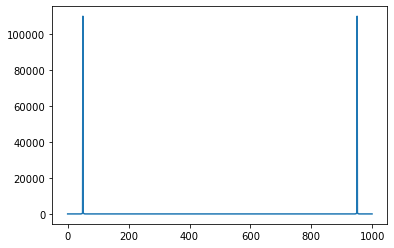

In [6]:
# 以10Hz频率窗为例，采样频率1kHz，找出对应对称频率窗，其余置零
for i in range(N):
    if (f[i] <= 55 and f[i] >= 45) or (f[i] <= 955 and f[i] >= 945):
        fft_y[i] = fft_y[i]
    else:
        fft_y[i] = 0
plt.plot(f, np.abs(fft_y))


In [7]:
ifft_y = np.real(ifft(fft_y))

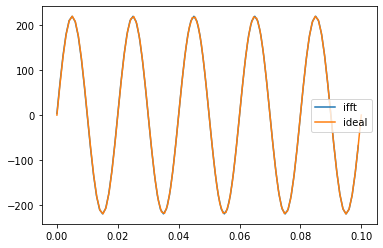

In [8]:
# 对比还原后信号与目标信号
plt.plot(x[:100], ifft_y[:100], label='ifft')
plt.plot(np.linspace(0, 0.1, 100), 220*np.sin(2*np.pi *
         50*np.linspace(0, 0.1, 100)), label='ideal')
plt.legend(loc='best')

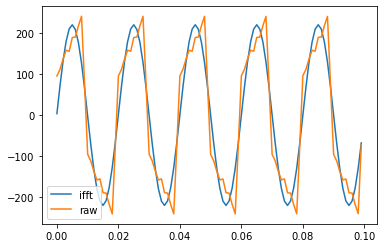

In [9]:
# 对比还原后信号与原始信号
plt.plot(x[:100], ifft_y[:100], label='ifft')
plt.plot(x[:100], y[:100], label='raw')
plt.legend(loc='best')


In [10]:
# 计算THD


def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))


def get_thd(fundamental, raw):
    return math.sqrt((get_rms(raw) ** 2 - get_rms(fundamental) ** 2) / get_rms(fundamental) ** 2)


thd = get_thd(ifft_y, y)

print("Total Harmonic Distortion is: {}".format(thd))

Total Harmonic Distortion is: 0.34996709019105426
